## パッケージ導入

In [1]:
!pip install --upgrade google-genai japanize_matplotlib

  Attempting uninstall: google-genai
    Found existing installation: google-genai 1.17.0
    Uninstalling google-genai-1.17.0:
      Successfully uninstalled google-genai-1.17.0


In [14]:
import IPython
app = IPython.Application.instance()
_ = app.kernel.do_shutdown(True)

## 事前準備

In [1]:
import vertexai
PROJECT_ID = !gcloud config get-value project
PROJECT_ID = PROJECT_ID[-1]
LOCATION = 'us-central1'

vertexai.init(project=PROJECT_ID, location='us-central1')

BUCKET = f'gs://{PROJECT_ID}-handson'

In [2]:
target_s = f'{BUCKET}/mp4/s_大規模言語モデルを支える分散学習インフラ Pathways.mp4'
target_n = f'{BUCKET}/mp4/n_大規模言語モデルを支える分散学習インフラ Pathways.mp4'

In [3]:
import base64, copy, json, os, re, time, uuid
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image

import vertexai
from google.cloud import storage
from google import genai
from google.genai import types
from google.genai.types import (
    HttpOptions, GenerateContentConfig, GenerateImagesConfig,
    Part, UserContent, ModelContent,
)

import os, json, datetime, pprint
import numpy as np

from IPython.display import Image, display, HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import japanize_matplotlib

In [4]:
def generate_response(system_instruction, contents,
                      response_schema, model='gemini-2.0-flash-001'):
    client = genai.Client(vertexai=True,
                          project=PROJECT_ID, location=LOCATION,
                          http_options=HttpOptions(api_version='v1'))
    response = client.models.generate_content(
        model=model,
        contents=contents,
        config=GenerateContentConfig(
            system_instruction=system_instruction,
            temperature=0.1,
            response_mime_type='application/json',
            response_schema=response_schema,
        )
    )
    return '\n'.join(
        [p.text for p in response.candidates[0].content.parts if p.text]
    )

In [5]:
def load_json(text):
    text = text.replace('```json', '').replace('```', '').replace('\n', ' ')
    return json.loads(text)

In [6]:
!gsutil ls -l {BUCKET}/mp4/s*

  41642532  2025-05-29T14:43:24Z  gs://movie-search-metadeta-test-handson/mp4/s_Enabling passkeys with Hybrid on non-passkey-supported device.mp4
  24857097  2025-02-03T02:33:52Z  gs://movie-search-metadeta-test-handson/mp4/s_Google Cloud Next Tokyo ’24 - Innovators Hive の Day 0 に潜入！ -.mp4
  45744432  2025-05-29T14:54:47Z  gs://movie-search-metadeta-test-handson/mp4/s_NTTドコモがDatadogで開発スピードを4倍、故障発生回数を1 3以下にした方法.mp4
  29072758  2025-05-29T14:04:00Z  gs://movie-search-metadeta-test-handson/mp4/s_NTTドコモのサービスシステムにおけるDevOps推進とPagerDutyによる運用効率.mp4
  79086515  2025-05-29T18:33:31Z  gs://movie-search-metadeta-test-handson/mp4/s_datadog.mp4
   5514908  2025-02-03T02:33:50Z  gs://movie-search-metadeta-test-handson/mp4/s_千葉県印西市にデータセンターを開設.mp4
  30815449  2025-02-03T02:33:51Z  gs://movie-search-metadeta-test-handson/mp4/s_大規模言語モデルを支える分散学習インフラ Pathways.mp4
TOTAL: 7 objects, 256733691 bytes (244.84 MiB)


**注意**

次のコマンドを実行するとプロジェクト内でキャッシュ中のデータをすべて削除できます。

キャッシュ中のデータに対する不要な課金を避けるために、検証が完了したら実行しておくことをお勧めします。

```
for item in caching.CachedContent.list():
    cached_content = caching.CachedContent(
        f'projects/{item.project}/locations/{item.location}/cachedContents/{item.name}')
    cached_content.delete()
```

In [6]:
filename = target_s.split('/')[-1]
basename = filename.rstrip('.mp4').lstrip('s_')
image_dir = f'{BUCKET}/image/{basename}'
gsutil_opt = '-o GSUtil:parallel_composite_upload_threshold=150M'
local_image_dir = basename

In [ ]:
# 静止画像ファイルをローカルにコピー
!gsutil -m {gsutil_opt} cp -r "{image_dir}" ./

## キャラクター抽出（Optional）

In [8]:
system_instruction = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Find characters in the movie and describe the visual appearance of each character as detailed as possible.
B. Identify the name of each character you found on task A. If you cannot identify the name, name it "Unknown".
C. Identify representative scenes for each character where the character visually appears on the screen.

[condition]
B. The description has more than three sentences.
C. The number of scenes for each character is at most three. Each scene is identified with timestamp mm:ss-mm:ss.

[format instruction]
In Japanese. Output is a JSON list of "character dict". "character dict" is a JSON dict in the following format:
{
  "Character ID": <Sequential number starting from 1>,
  "Name": "<Character name>",
  "Visual Description": "<Visual appearance>",
  "Scenes": [ "<list of timestamp of representative scenes>" ]
}
'''

response_schema = {
    "type": "array",
    "items": {
            "type": "object",
            "properties": {
                "Character ID": {"type": "string",
                                 "description": "Sequential number starting from 1"
                },
                "Name" : {"type": "string",
                          "description": "Character name"
                },
                "Visual Description": {"type": "string",
                                       "description": "Visual appearance of the character"
                },
                "Scenes": {"type": "array",
                           "items": {
                              "type": "string"
                           },
                           "description": "list of timestamp of representative scenes"
                },
            },
            "required": [
                "Character ID",
                "Name",
                "Visual Description",
                "Scenes"
            ],

    }
}

In [9]:
contents = UserContent([
    Part.from_text(text='[movie]'),
    Part.from_uri(file_uri=target_n, mime_type='video/mp4'),
])

result = generate_response(system_instruction, contents,
                           response_schema=response_schema,
                           model='gemini-2.0-flash-001')
print(result)

[
  {
    "Character ID": "1",
    "Name": "中井 悦司 / Etsuji Nakai",
    "Visual Description": "彼はアジア系の男性で、黒髪で眼鏡をかけています。彼は黒いポロシャツを着ており、講演台の前に立っています。彼は落ち着いた様子で、時折笑顔を見せながら話しています。彼の表情は知的で、自信に満ち溢れています。",
    "Scenes": [
      "00:17-00:22",
      "01:10-01:15",
      "02:25-02:30"
    ]
  },
  {
    "Character ID": "2",
    "Name": "北瀬 公彦",
    "Visual Description": "彼はアジア系の男性で、短く刈り上げた髪型をしています。彼は黒縁の眼鏡をかけており、白いTシャツの上に紺色のジャケットを羽織っています。彼は落ち着いた様子で、時折笑顔を見せながら話しています。",
    "Scenes": [
      "18:30-18:35",
      "19:10-19:15",
      "20:30-20:35"
    ]
  }
]


=====
1 中井 悦司 / Etsuji Nakai 彼はアジア系の男性で、黒髪で眼鏡をかけています。彼は黒いポロシャツを着ており、講演台の前に立っています。彼は落ち着いた様子で、時折笑顔を見せながら話しています。彼の表情は知的で、自信に満ち溢れています。


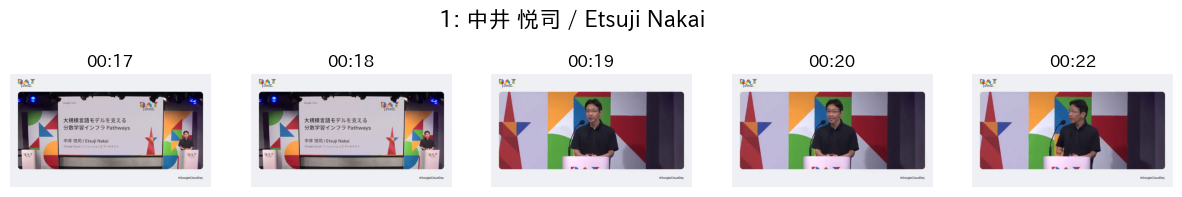

<Figure size 640x480 with 0 Axes>

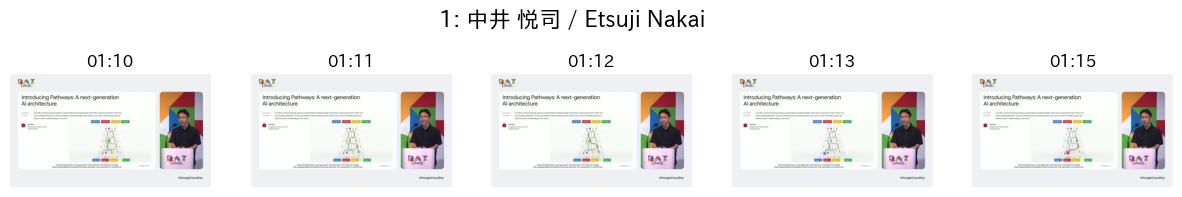

<Figure size 640x480 with 0 Axes>

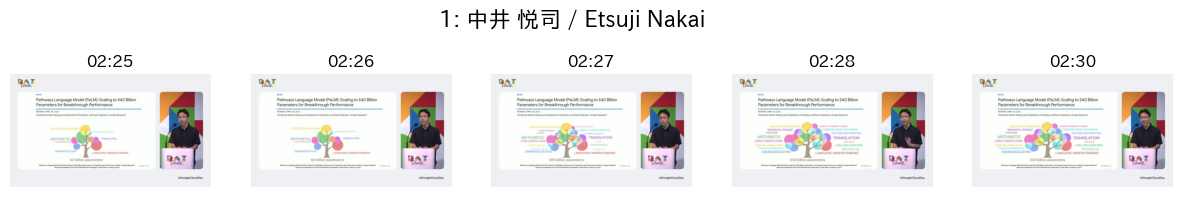

=====
2 北瀬 公彦 彼はアジア系の男性で、短く刈り上げた髪型をしています。彼は黒縁の眼鏡をかけており、白いTシャツの上に紺色のジャケットを羽織っています。彼は落ち着いた様子で、時折笑顔を見せながら話しています。


<Figure size 640x480 with 0 Axes>

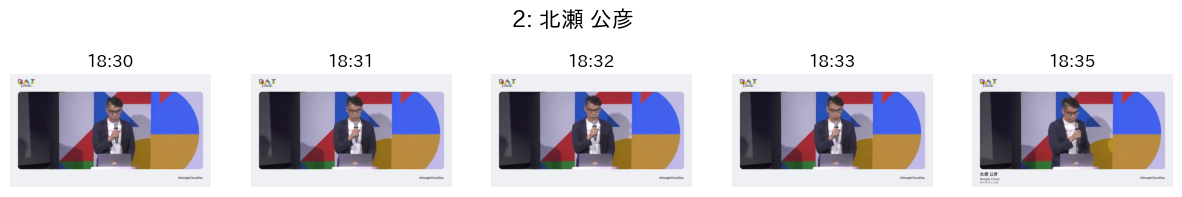

<Figure size 640x480 with 0 Axes>

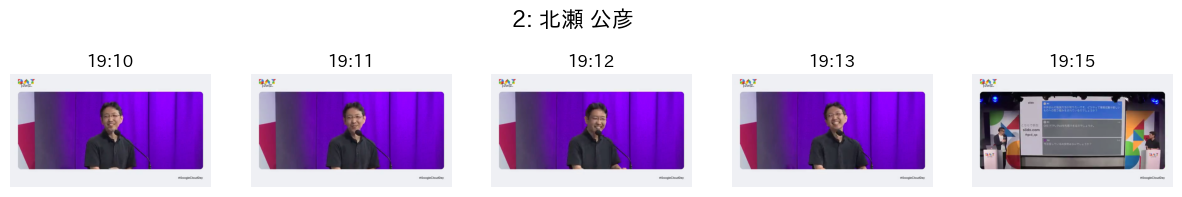

<Figure size 640x480 with 0 Axes>

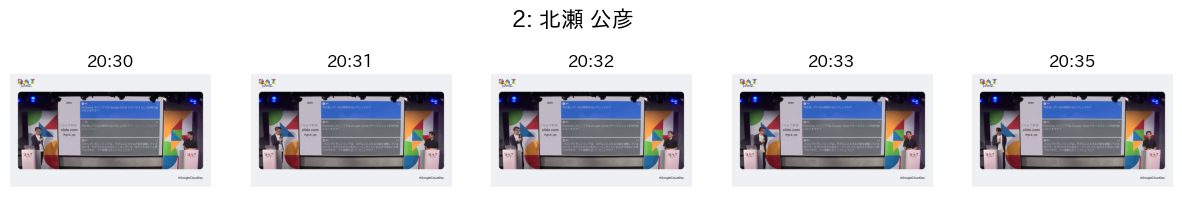

<Figure size 640x480 with 0 Axes>

In [10]:
scenes = load_json(result)
jpg_files = !ls "{local_image_dir}/"
m = 0
for c in [s.lstrip('capture').rstrip('.jpg') for s in jpg_files]:
    try:
        m = max(m, int(c))
    except:
        pass

for item in scenes:
    print('=====')
    print(item['Character ID'], item['Name'], item['Visual Description'])
    for ts in item['Scenes'][:3]:
        ts1, ts2 = ts.split('-')
        m1, s1 = ts1.split(':')
        ss1 = int(m1) * 60 + int(s1) + 1
        m2, s2 = ts2.split(':')
        ss2 = int(m2) * 60 + int(s2) + 1
        
        fig, axs = plt.subplots(1, 5, figsize=(15, 2.5))  # Adjust figsize as needed
        axs = axs.ravel()
        fig.suptitle(str(item['Character ID']) + ': ' + item['Name'], fontsize=16)
        for c, ts in enumerate(np.linspace(max(1, ss1), min(ss2, m), 5)):
            ts = int(ts)
            mm, ss = divmod(ts - 1, 60)
            image_name = f'{local_image_dir}/capture{ts:04d}.jpg'
            img = mpimg.imread(image_name)
            axs[c].imshow(img)
            axs[c].axis('off')
            axs[c].set_title(f'{mm:02d}:{ss:02d}')
        plt.show()
        plt.clf()

キャラクター名はハルシネーションが起きている可能性があるので、外見の記述と参考画像を元にネット検索で正しい名前を検索して、参照用画像ファイルを別途用意

In [11]:
chars = !gsutil ls "{image_dir}/characters/*.png"
chars

['gs://movie-search-metadeta-test-handson/image/大規模言語モデルを支える分散学習インフラ Pathways/characters/中井 悦司.png',
 'gs://movie-search-metadeta-test-handson/image/大規模言語モデルを支える分散学習インフラ Pathways/characters/北瀬 公彦.png']

In [16]:
prompt_reference = [
    '\n[Reference information to identify character names]'
]
image_files = {}
for item in chars:
    name = item.split('/')[-1].rstrip('.png')
    image_files[name] = item
    prompt_reference += [
        f'The name of following character is "{name}"',
        Part.from_uri(file_uri=image_files[name], mime_type='image/png')
    ]

prompt_reference

['\n[Reference information to identify character names]',
 'The name of following character is "中井 悦司"',
 Part(video_metadata=None, thought=None, inline_data=None, file_data=FileData(display_name=None, file_uri='gs://movie-search-metadeta-test-handson/image/大規模言語モデルを支える分散学習インフラ Pathways/characters/中井 悦司.png', mime_type='image/png'), thought_signature=None, code_execution_result=None, executable_code=None, function_call=None, function_response=None, text=None),
 'The name of following character is "北瀬 公彦"',
 Part(video_metadata=None, thought=None, inline_data=None, file_data=FileData(display_name=None, file_uri='gs://movie-search-metadeta-test-handson/image/大規模言語モデルを支える分散学習インフラ Pathways/characters/北瀬 公彦.png', mime_type='image/png'), thought_signature=None, code_execution_result=None, executable_code=None, function_call=None, function_response=None, text=None)]

## 動画サマリー

In [9]:
system_instruction = ''

In [14]:
prompt_summary = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Give an one sentence summary of the movie that can be used as a title of the movie.
B. Summarize the content of the movie in five to ten sentences.

[condition]
A, B. If possible, identify the names of characters. Use the full name on every part of the output.
A, B. The output should be based on the objective information in the movie.

[format instruction]
Answer in Japanese. In the JSON dict with the following format:
{
  "Title": "<Output of Task A>",
  "Summary": "<Output of Task B>"
}
'''

response_schema = {
    "type": "array",
    "items": {
            "type": "object",
            "properties": {
                "Title": {"type": "string",
                },
                "Summary" : {"type": "string",
                },
            },
            "required": [
                "Title",
                "Summary",
            ],

    }
}

In [15]:
contents = UserContent([
    Part.from_text(text=prompt_summary),
    Part.from_uri(file_uri=target_n, mime_type='video/mp4'),
])

result = generate_response(system_instruction, contents,
                           response_schema=response_schema,
                           model='gemini-2.0-flash-001')
print(result)

[
  {
    "Title": "大規模言語モデルを支える分散学習インフラPathwaysの紹介",
    "Summary": "この動画では、Google Cloudのソリューションアーキテクトである中井 悦司氏が、大規模言語モデルを支える分散学習インフラPathwaysについて解説します。中井 悦司氏は自己紹介として、機械学習、強化学習、深層学習、スケーラブルデータサイエンスに関する書籍を紹介しました。Pathwaysは、複数のタスクを同時に処理し、新しいタスクを迅速に学習し、世界をより良く理解することを反映する新しいAIアーキテクチャです。Pathways言語モデル（PaLM）は、質問応答、算術、翻訳、言語理解、要約などのタスクを実行するために、5400億のパラメータにスケーリングされています。Pathwaysのインフラストラクチャを使用した学習処理の例として、Transformerを使用した自然言語モデルが挙げられます。モデルサイズの拡大に伴う性能向上は今後も継続すると期待される一方、巨大なモデルを学習するためのインフラには限界があることが述べられています。"
  }
]


In [16]:
summary = pprint.pformat(load_json(result))

## 重要シーン抽出

In [17]:
prompt_important_scenes = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Find around 15 important scenes in the movie with accurate timestamps.
B. Give a short summary of each scene and why that scene is important.

[condition]
A, B. If possible, identify the names of characters. Use the full name on every part of the output.
The [summary] section contains the summary of the entire movie.
You don't need to use the summary information to find scenes, but the result should be consistent with the summary.

[format instruction]
In Japanese. Show only the following information.
Output in a comma separated list with two columns: <timestamp mm:ss-mm:ss>, <output of task B>
Header is: Timestamp, Description

[summary]
''' + summary

In [18]:
contents = UserContent([
    Part.from_text(text=prompt_important_scenes),
    Part.from_uri(file_uri=target_n, mime_type='video/mp4'),
])

important_scenes = generate_response(system_instruction, contents, response_schema=None, model='gemini-2.0-flash-001')
print(important_scenes)

{
 "results": [
  {
   "Timestamp": "00:17-00:33",
   "Description": "中井悦司氏が自己紹介を行い、機械学習、強化学習、深層学習、スケーラブルデータサイエンスに関する書籍を紹介します。"
  },
  {
   "Timestamp": "00:34-00:52",
   "Description": "Pathwaysが、複数のタスクを同時に処理し、新しいタスクを迅速に学習し、世界をより良く理解することを反映する新しいAIアーキテクチャであることが説明されます。"
  },
  {
   "Timestamp": "01:53-02:02",
   "Description": "Pathways言語モデル（PaLM）が、質問応答、算術、翻訳、言語理解、要約などのタスクを実行するために、5400億のパラメータにスケーリングされていることが示されます。"
  },
  {
   "Timestamp": "03:20-03:37",
   "Description": "ディープラーニング実用化のきっかけとなった2012年の発表について説明します。"
  },
  {
   "Timestamp": "04:28-04:47",
   "Description": "自然言語モデル/翻訳モデルでは、モデルの基本構造が同じであれば、「計算量、モデルサイズ、データ量」が予測性能により大きな影響を与えるという経験則について説明します。"
  },
  {
   "Timestamp": "05:12-05:27",
   "Description": "GPT-3モデルとGLaMモデルのパラメータ数と性能を比較し、GLaMモデルがGPT-3に対して性能向上していることを示します。"
  },
  {
   "Timestamp": "05:56-06:15",
   "Description": "テキストから画像を生成するモデルであるXMC-GANについて説明します。"
  },
  {
   "Timestamp": "06:15-06:39",
   "Description": "テキストから画像を生成するモデルであるImagenについて説明します。"
  },
  {
   "Timestamp

## シーン情報（ビジュアル情報）取得

In [7]:
prompt_visuals = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Split the entire movie into scenes with accurate timestamps from start to the exact end of the movie file.
B. Describe what's happening in the scene as detailed as possible.
C. Enrich the output of task B by adding visual information of not only characters but also things in the background.

[condition]
A. The length of each scene is 1 to 15 seconds.
 - Good example: 00:05-00:08, 00:05-00:18. / Bad example: 00:05-01:14 as the timestamp jumps more than 15 seconds.
B, C. Avoid using audio information to describe the scene. Describle only what you see on the screen.
B. If possible, identify the names of characters. Use the full name on every part of the output.
C. The final description is very detailed, vivid and realistic to covey all the visual information of the scene, using up to three sentences.

[format instruction]
In Japanese. Show only the following information.
Output in a comma separated list with two columns: <timestamp mm:ss-mm:ss>, <output of task C>
Header is: Timestamp, Description
'''

In [10]:
contents = UserContent([
    Part.from_text(text=prompt_visuals),
    Part.from_uri(file_uri=target_n, mime_type='video/mp4'),
])

visual_info = generate_response(system_instruction, contents, response_schema=None, model='gemini-2.5-pro-preview-05-06')
print(visual_info)

[
  {
    "Timestamp": "00:00-00:01",
    "Description": "真っ白な画面から、画面上部からカラフルな幾何学模様で構成された「DAY」という文字のロゴがゆっくりと現れる。背景は一貫して白である。"
  },
  {
    "Timestamp": "00:01-00:04",
    "Description": "画面中央にカラフルな「DAY」のロゴが表示され、その下に黒い文字で「Breakout」という単語が現れ、続いて「Session」という単語が追加される。背景には、ロゴと同様のカラフルな幾何学模様の破片がアニメーションしながら散りばめられている。"
  },
  {
    "Timestamp": "00:04-00:11",
    "Description": "白い背景のタイトルスライド。左上に「Google Cloud」のロゴ、右上には「DAY Tourz」のロゴが表示されている。中央には黒い太字で「大規模言語モデルを支える 分散学習インフラ Pathways」という日本語のタイトル、その下に「中井 悦司 / Etsuji Nakai」と「Google Cloud / ソリューションズアーキテクト」という文字が続く。右下にはカラフルな幾何学模様で構成された塔のようなイラストが配置されている。"
  },
  {
    "Timestamp": "00:11-00:16",
    "Description": "実際のステージの様子が映し出される。中央の大きなスクリーンには前のシーンと同じタイトルスライドが表示されている。スクリーンの右側では、黒い半袖ポロシャツに眼鏡をかけた中井悦司氏が、「DAY Tourz」ロゴ入りの白い演台の後ろに立っている。ステージの背景はカラフルな幾何学模様のパネルで装飾され、上部には青いスポットライトが見える。画面右下には「#GoogleCloudDay」のハッシュタグが表示されている。"
  },
  {
    "Timestamp": "00:16-00:22",
    "Description": "演台に立つ中井悦司氏のクローズアップ。氏は眼鏡をかけ、黒い半袖の襟付きシャツを着用している。背景にはカラフルな幾何学模様のパネルが見える。氏は少し左を向き

## 音声文字起こし

In [ ]:
prompt_transcription = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Transcript what they are speaking exactly with accurate timestamps.

[condition]
A. Process the entire movie from start to the exact end of the movie file.
A. Identify the name of person who is speaking for each speech. Use the full name on every part of the output. If you cannot identify the name, name it "Unknown".
A. Keep consistency between timestamp and transcript in the movie file.

[format instruction]
In Japanese. Output is a JSON list of "speech dict". "speech dict" is a JSON dict in the following format:
{
  "timestamp": "<mm:ss-mm:ss>",
  "Name": "<Name of the speaker>",
  "Transcription": "<Transcription>"
}
'''

response_schema = {
    "type": "array",
    "items": {
            "type": "object",
            "properties": {
                "timestamp": {"type": "string",
                              "description": "<mm:ss-mm:ss>"
                },
                "Name" : {"type": "string",
                          "description": "Name of the speaker"
                },
                "Transcription": {"type": "string",
                                  "description": "Transcription"
                },
            },
            "required": [
                "timestamp",
                "Name",
                "Transcription",
            ],

    }
}

In [45]:
contents = UserContent([
    Part.from_text(text=prompt_transcription),
    Part.from_uri(file_uri=target_s, mime_type='video/mp4'),
])
result = generate_response('Process the entire movie from start to the exact end of the movie file.', contents,
                           response_schema=response_schema,
                           model='gemini-2.5-pro-preview-05-06')
print(result)

[
  {"timestamp": "00:14-00:26", "Name": "中井 悦司", "Transcription": "はい、皆さんこんにちは。Google Cloud ソリューションズアーキテクトの中井です。え、今日私の方からはこちらのタイトルで、ま、約30分間お話をさせていただきます。よろしくお願いいたします。"},
  {"timestamp": "00:28-00:32", "Name": "中井 悦司", "Transcription": "はい、で、こちらいつもの自己紹介スライドですね。よろしくお願いいたします。"},
  {"timestamp": "00:33-01:52", "Name": "中井 悦司", "Transcription": "で、早速中身の方入っていきたいと思いますが、今日私のセッションのタイトルの中にパスウェイズというキーワードがありました。このキーワード皆さん聞いたことありますでしょうか?え、実はパスウェイズという言葉が初めて登場したのがこちらのブログ記事なんですね。2021年、2年前に、え、Googleの、え、機械学習ML研究チームのトップですね、ジェフディーンが発表したブログ記事になります。で、このブログの中でジェフディーンは、ま、今後の将来の機械学習モデルのアーキテクチャーを語っているんですね。従来の機械学習モデルというのは基本的にはえ、シングルモーダル、シングルタスクなんか特定の形式のデータだけを扱って、何か特定のタスク、特定の仕事をするために、ま、専用に、えっと、チューニングされた開発されたモデルというのが基本でした。で、それに対して今後はマルチモーダル、マルチタスクいろんな形式のデータを同時に取り扱って、かつ、え、いろんなタスクを並列にこなしていく、そんな機械学習モデルが主流になっていく。ま、少なくともGoogleの研究チームはそういったモデルの開発をこれから目指していくということを語っているんですね。"},
  {"timestamp": "01:52-02:28", "Name": "中井 悦司", "Transcription": "で、その後翌年なんですけども、またこのパスウェイズというキーワードが登場しました。これ昨年のGoogle IOでも語られていたので覚えてる方いらっしゃるかもしれま

In [46]:
transcription = pprint.pformat(load_json(result))

## テキスト情報取得

In [59]:
prompt_texts = '''\
You are a video content editor. Work on the following tasks.

[task]
A. Extract exact text strings from each scene.

[steps]
2. Extract text strings from the scene.
3. Output the new "text dict" that have the "Text" element. "Timestamp" and "Layout" should be the same as the original item.

[condition]
A. Process the entire movie from start to the exact end of the movie file.A. Output each character literally as on the screen. Don't modify them.
A. Use a list to store multiple lines of texts instead of using the return code \\n in the extracted text strings.
A. Make sure to use double quotes "" in the output JSON.

[format instruction]
Final output is a JSON list of "text dict". "text dict" is a JSON dict in the following format:
{
  "Timestamp": "<Timestamp mm:ss-mm:ss>",
  "Text": [List of text strings from Task A>],
  "Layout": "<layout description>"
}

[text layout]
'''

response_schema = {
    "type": "array",
    "items": {
            "type": "object",
            "properties": {
                "Timestamp": {"type": "string",
                              "description": "<Timestamp mm:ss-mm:ss>"
                },
                "Text": {"type": "array",
                           "items": {
                              "type": "string"
                           },
                           "description": "List of text strings from Task A>"
                },
                "Layout" : {"type": "string",
                            "description": "<layout description>"
                },
            },
            "required": [
                "Timestamp",
                "Text",
                "Layout",
            ],

    }
}

result = generate_response('Process the entire movie from start to the exact end of the movie file.', contents,
                           response_schema=response_schema,
                           model='gemini-2.5-pro-preview-05-06')
print(result)

[
  {
    "Timestamp": "00:01-00:02",
    "Text": [],
    "Layout": "Logo in the center with animated geometric shapes."
  },
  {
    "Timestamp": "00:02-00:03",
    "Text": [
      "Breakout"
    ],
    "Layout": "Text in the center with animated geometric shapes in the background."
  },
  {
    "Timestamp": "00:03-00:04",
    "Text": [
      "Breakout Session"
    ],
    "Layout": "Text in the center with animated geometric shapes in the background."
  },
  {
    "Timestamp": "00:04-00:11",
    "Text": [
      "Google Cloud",
      "大規模言語モデルを支える",
      "分散学習インフラ Pathways",
      "中井 悦司 / Etsuji Nakai",
      "Google Cloud / ソリューションズ アーキテクト"
    ],
    "Layout": "Title slide with text on the left, Google Cloud logo top-left, Day Tour '22 logo top-right, and a graphic element on the right."
  },
  {
    "Timestamp": "00:11-00:16",
    "Text": [
      "Google Cloud",
      "大規模言語モデルを支える",
      "分散学習インフラ Pathways",
      "中井 悦司 / Etsuji Nakai",
      "Google Cloud / ソリューションズ アーキテクト",
 

In [60]:
texts = result

## テキストベースの動画内検索

In [61]:
prompt_content_search = '''
You are a video content editor.

Given the following information of a movie:
- The [summary] section contains the summary of the movie.
- The [important scenes] section contains the important scenes of the movie with timestamps.
- The [visual info] section contains the visual information on what's happening in each scene with timestamps.
- The [transcription] section contains speech transcription with timestamps.
- The [text] section contains text information with timestamps.

Find one to three scenes that matches the user query with timestamps.

[format instruction]
Output in Japanese. Output is a JSON list with "scene dict".
Each "scene dict" is a JSON dict with the following format:
{{
  "Timestamp": "<timestamp mm:ss-mm:ss>",
  "Description": "<Explain how this scene matches the query.>",
  "Evidence": [<List of data snippets that support your result>]
}}

[user query]
{}

[summary]
{}

[important scenes]
{}

[visual info]
{}

[transcription]
{}

[texts]
{}
'''

response_schema = {
    "type": "array",
    "items": {
            "type": "object",
            "properties": {
                "Timestamp": {"type": "string",
                              "description": "<Timestamp mm:ss-mm:ss>"
                },
                "Description" : {"type": "string",
                            "description": "Explain how this scene matches the query."
                },
                "Evidence": {"type": "array",
                             "items": {
                                 "type": "string"
                             },
                             "description": "List of data snippets that support your result>"
                },
            },
            "required": [
                "Timestamp",
                "Description",
                "Evidence"
            ],

    }
}

In [62]:
def show_thumbnails(scenes):
    jpg_files = !ls "{local_image_dir}/"
    m = 0
    for c in [s.lstrip('capture').rstrip('.jpg') for s in jpg_files]:
        try:
            m = max(m, int(c))
        except:
            pass
    for item in scenes:
        ts = item['Timestamp']
        ts1, ts2 = ts.split('-')
        m1, s1 = ts1.split(':')
        ss1 = int(m1) * 60 + int(s1) + 1
        m2, s2 = ts2.split(':')
        ss2 = int(m2) * 60 + int(s2) + 1
        
        fig, axs = plt.subplots(1, 5, figsize=(15, 2))  # Adjust figsize as needed
        axs = axs.ravel()
        print('=====')
        print(str(item['Description']))
        # 報告されたタイムスタンプの前後 3 秒を含めて 5 枚の静止画像を表示する
        for c, ts in enumerate(np.linspace(max(1, ss1-3), min(ss2+3, m), 5)):
            ts = int(ts)
            mm, ss = divmod(ts - 1, 60)
            image_name = f'{local_image_dir}/capture{ts:04d}.jpg'
            img = mpimg.imread(image_name)
            axs[c].imshow(img)
            axs[c].axis('off')
            axs[c].set_title(f'{mm:02d}:{ss:02d}')
        plt.show()
        plt.clf()

In [63]:
%%time
query = 'ニューラルスケーリングについて解説しているシーン'
prompt = prompt_content_search.format(
    query, summary, important_scenes, visual_info, transcription, texts)
# result = generate(prompt, model=model_flash)

contents = UserContent([
    Part.from_text(text=prompt),
    Part.from_uri(file_uri=target_n, mime_type='video/mp4'),
])
result = generate_response(system_instruction, contents,
                           response_schema=response_schema,
                           model='gemini-2.0-flash-001')
print(result)

[
  {
    "Timestamp": "04:27-05:12",
    "Description": "このシーンでは、自然言語モデルの場合、モデルに含まれるパラメータ数を増やせば増やすほど性能が良くなるという経験則であるニューラルスケーリングローについて説明しています。",
    "Evidence": [
      "え、機械学習モデル、ディープラーニングモデルのサイズがどんどんんどんどん大きくなっていくとえ、いう流れがあります。",
      "で、これ理由色々あるんですけども、1つ分かりやすいのがやっぱりモデルのサイズが大きいほど性能が上がるんですね。",
      "実際これ理論的にはまだ解明されてないんですけども、少なくとも経験的には特にあの自然言語を扱う自然言語モデルの場合はモデルの構造自体が基本的に変わらなければ、ま、とにかくそのモデルにえ、含まれるパラメーター数を増やせば増やすほど性能が良くなるということが知られていてえ、ニューラルスケーリングローという名前がついています。"
    ]
  },
  {
    "Timestamp": "04:26-04:32",
    "Description": "画面には「Neural scaling laws」という文字が表示され、中井悦司が演台の前に立って説明しています。このシーンはニューラルスケーリングについて解説していることを示しています。",
    "Evidence": [
      "画面には「Neural scaling laws」という文字が表示され、中井悦司が演台の前に立って説明している。"
    ]
  },
  {
    "Timestamp": "04:32-04:38",
    "Description": "画面には「Neural scaling laws」という文字が表示され、中井悦司が演台の前に立って説明しています。このシーンはニューラルスケーリングについて解説していることを示しています。",
    "Evidence": [
      "画面には「Neural scaling laws」という文字が表示され、中井悦司が演台の前に立って説明している。"
    ]
  }
]
CPU times: user 34.4 ms, sys: 

=====
このシーンでは、自然言語モデルの場合、モデルに含まれるパラメータ数を増やせば増やすほど性能が良くなるという経験則であるニューラルスケーリングローについて説明しています。


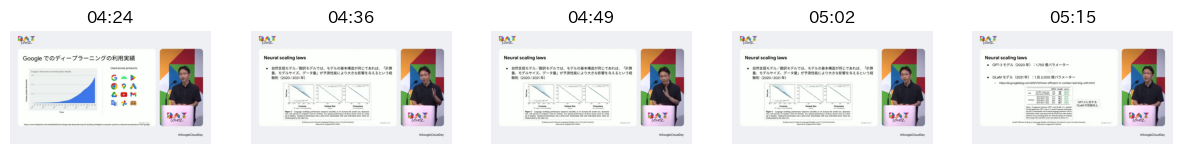

=====
画面には「Neural scaling laws」という文字が表示され、中井悦司が演台の前に立って説明しています。このシーンはニューラルスケーリングについて解説していることを示しています。


<Figure size 640x480 with 0 Axes>

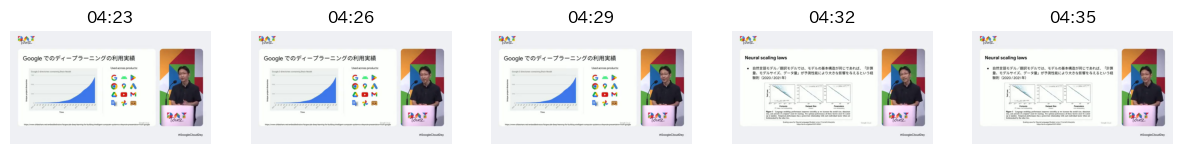

=====
画面には「Neural scaling laws」という文字が表示され、中井悦司が演台の前に立って説明しています。このシーンはニューラルスケーリングについて解説していることを示しています。


<Figure size 640x480 with 0 Axes>

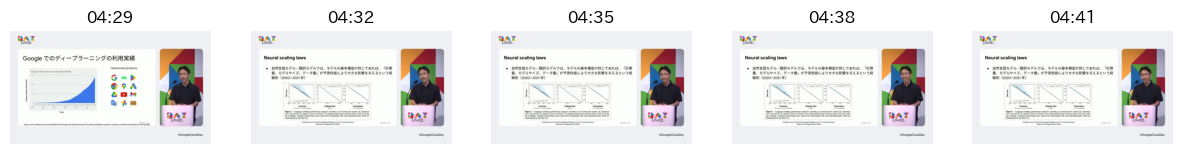

<Figure size 640x480 with 0 Axes>

In [64]:
show_thumbnails(load_json(result))

In [65]:
%%time
query = '視聴者からの質問に答えているシーン'
prompt = prompt_content_search.format(
    query, summary, important_scenes, visual_info, transcription, texts)

contents = UserContent([
    Part.from_text(text=prompt),
    Part.from_uri(file_uri=target_n, mime_type='video/mp4'),
])

result = generate_response(system_instruction, contents,
                           response_schema=response_schema,
                           model='gemini-2.0-flash-001')
print(result)

[
  {
    "Timestamp": "18:24-18:50",
    "Description": "北瀬氏が視聴者からの質問を読み上げ、中井氏に質問をしています。質問は中井さんの勉強方法についてです。",
    "Evidence": [
      "え、それではですね、早速QAに移りたいと思います。引き続きQAの進行を務めますGoogle Cloudマーケティングの北瀬です。よろしくお願いします。",
      "中井さん、引き続きよろしくお願いします。はい、よろしくお願いします。",
      "じゃあ早速ですけどね、え、1番上の質問から行きたいと思います。中井さんの勉強方法が知りたいです。どうやって情報収集や新しいものへの取り組みをされているのでしょうかというところですけどいかがでしょう。"
    ]
  },
  {
    "Timestamp": "19:12-19:19",
    "Description": "視聴者からの質問に対して、中井氏が答えています。質問はGKEでTPUポッドを利用できるかについてです。",
    "Evidence": [
      "え、次ですね、え、GKEでTPUポッド利用できるのでしょうか。",
      "はい、ありがとうございます。えっと現状ではTPUポッドをダイレクトにGKEにアサインするっていうのはなかった気がしますね。あの、別途TPUポッドをえっと、Google Cloud上で用意してま、GKEからえっとタスクを投げるっていうのはもちろんできますが、ちょっとGKEとダイレクトなインテグレーションはすいません私の知る範囲ではまだなかったと思います。"
    ]
  },
  {
    "Timestamp": "19:47-19:55",
    "Description": "視聴者からの質問に対して、中井氏が答えています。質問はパスウェイズのインフラはGoogle Cloudのサービスとして利用可能になるかについてです。",
    "Evidence": [
      "多分あのこの下の質問も似たような感じになるんですかね。パスウェイズのインフラはGoogle Cloudのサービスとして利用可能になりますか。"
    ]
  },
  {
    "Timesta

=====
北瀬氏が視聴者からの質問を読み上げ、中井氏に質問をしています。質問は中井さんの勉強方法についてです。


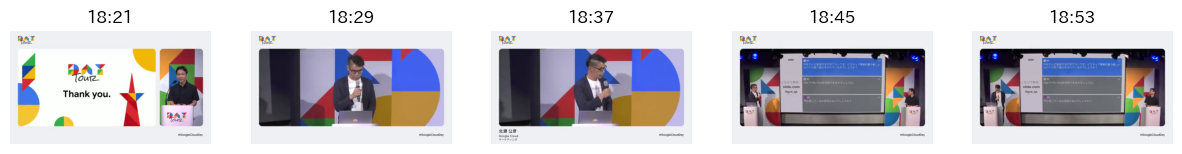

=====
視聴者からの質問に対して、中井氏が答えています。質問はGKEでTPUポッドを利用できるかについてです。


<Figure size 640x480 with 0 Axes>

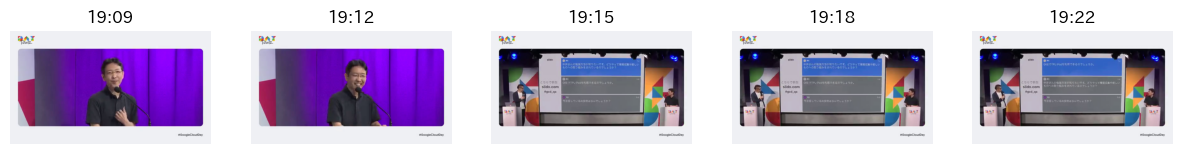

=====
視聴者からの質問に対して、中井氏が答えています。質問はパスウェイズのインフラはGoogle Cloudのサービスとして利用可能になるかについてです。


<Figure size 640x480 with 0 Axes>

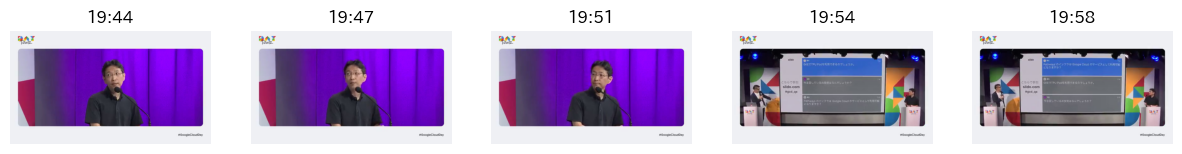

=====
視聴者からの質問に対して、中井氏が答えています。質問はパスウェイズのインフラはGoogle Cloudのサービスとして利用可能になるかについてです。


<Figure size 640x480 with 0 Axes>

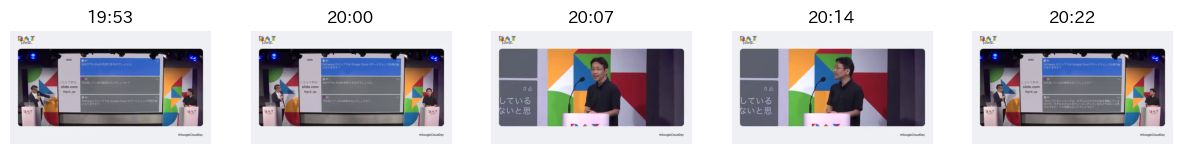

=====
視聴者からの質問に対して、中井氏が答えています。質問は今注目しているAI技術は何かについてです。


<Figure size 640x480 with 0 Axes>

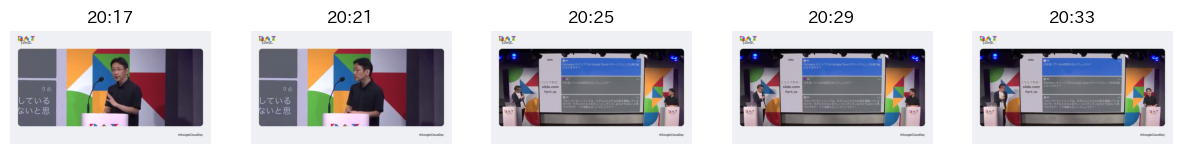

=====
視聴者からの質問に対して、中井氏が答えています。質問は今注目しているAI技術は何かについてです。


<Figure size 640x480 with 0 Axes>

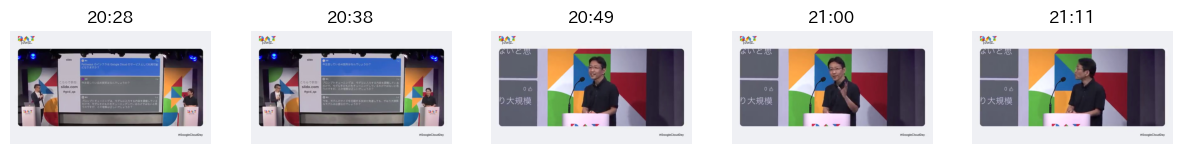

=====
視聴者からの質問に対して、中井氏が答えています。質問はプロンプトチューニングはモデルそのものをチューニングしているわけではないかについてです。


<Figure size 640x480 with 0 Axes>

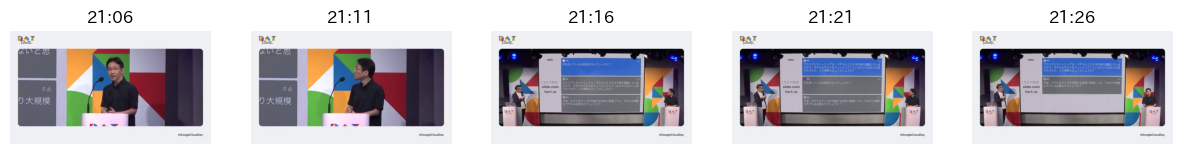

=====
視聴者からの質問に対して、中井氏が答えています。質問はプロンプトチューニングはモデルそのものをチューニングしているわけではないかについてです。


<Figure size 640x480 with 0 Axes>

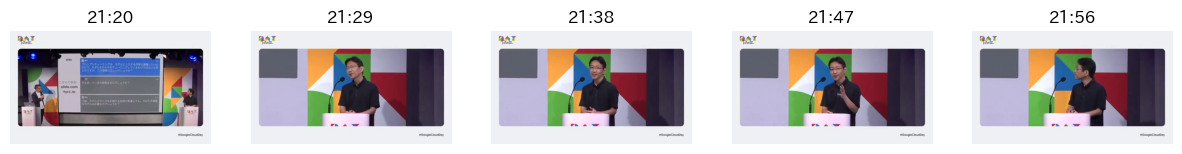

=====
視聴者からの質問に対して、中井氏が答えています。質問は今後モデルのサイズを圧縮する技術が発達しても大規模なモデルは必要かについてです。


<Figure size 640x480 with 0 Axes>

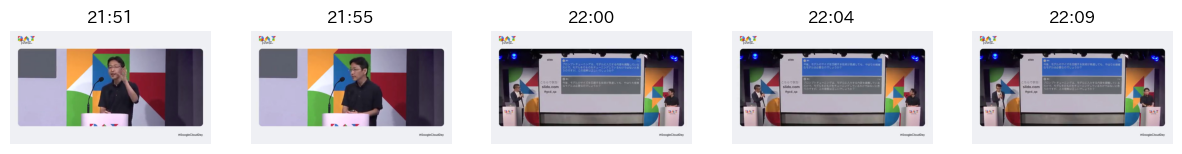

=====
視聴者からの質問に対して、中井氏が答えています。質問は今後モデルのサイズを圧縮する技術が発達しても大規模なモデルは必要かについてです。


<Figure size 640x480 with 0 Axes>

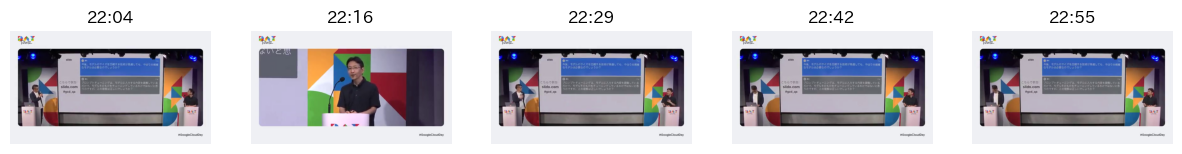

<Figure size 640x480 with 0 Axes>

In [66]:
show_thumbnails(load_json(result))

In [67]:
%%time
query = '発表者が大きく写っているシーン'
prompt = prompt_content_search.format(
    query, summary, important_scenes, visual_info, transcription, texts)

contents = UserContent([
    Part.from_text(text=prompt),
    Part.from_uri(file_uri=target_n, mime_type='video/mp4'),
])

result = generate_response(system_instruction, contents,
                           response_schema=response_schema,
                           model='gemini-2.0-flash-001')
print(result)

[
 {
  "Timestamp": "00:17-00:23",
  "Description": "中井悦司氏が白い演台の前に立って話しているシーンです。発表者が大きく写っているというクエリに合致します。",
  "Evidence": [
   "visual info: 中井悦司が白い演台の前に立って話している。背景には、白、赤、緑、黄色の幾何学模様が描かれたパネルが設置されている。画面の下部には「#GoogleCloudDay」と書かれている。"
  ]
 },
 {
  "Timestamp": "00:23-00:28",
  "Description": "中井悦司氏が白い演台の前に立って話しているシーンです。発表者が大きく写っているというクエリに合致します。",
  "Evidence": [
   "visual info: 中井悦司が白い演台の前に立って話している。画面の左下には「中井 悦司 Google Cloud ソリューションズアーキテクト」と書かれている。背景には、白、赤、緑、黄色の幾何学模様が描かれたパネルが設置されている。"
  ]
 },
 {
  "Timestamp": "03:20-03:26",
  "Description": "中井悦司氏が演台の前に立って説明しているシーンです。発表者が大きく写っているというクエリに合致します。",
  "Evidence": [
   "visual info: 画面には「ディープラーニング実用化のきっかけ（2012年の発表）」という文字が表示され、中井悦司が演台の前に立っている。背景には、白、赤、緑、黄色の幾何学模様が描かれたパネルが設置されている。画面の下部には「#GoogleCloudDay」と書かれている。"
  ]
 }
]
CPU times: user 34.2 ms, sys: 0 ns, total: 34.2 ms
Wall time: 22.5 s


=====
中井悦司氏が白い演台の前に立って話しているシーンです。発表者が大きく写っているというクエリに合致します。


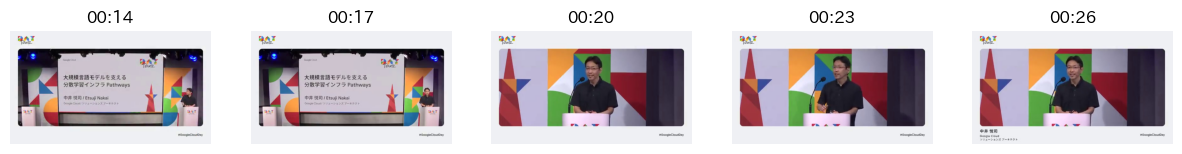

=====
中井悦司氏が白い演台の前に立って話しているシーンです。発表者が大きく写っているというクエリに合致します。


<Figure size 640x480 with 0 Axes>

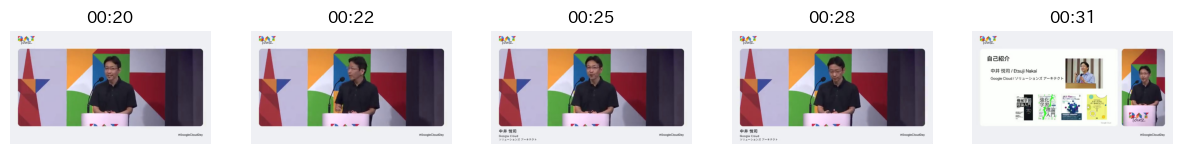

=====
中井悦司氏が演台の前に立って説明しているシーンです。発表者が大きく写っているというクエリに合致します。


<Figure size 640x480 with 0 Axes>

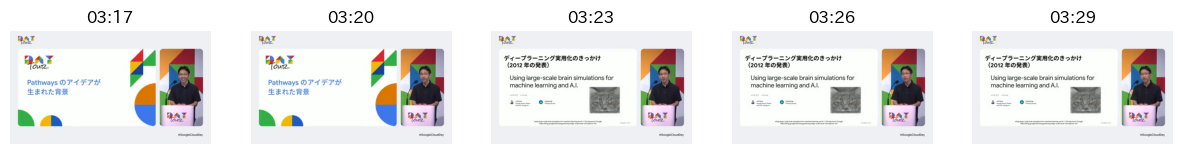

<Figure size 640x480 with 0 Axes>

In [68]:
show_thumbnails(load_json(result))

## 動画ベースの動画内検索

In [69]:
prompt_movie_content_search = '''\
You are a video content editor.
Find one to three scenes that matches the user query with timestamps.

[condition]
Try to identify names of characters.
The result should be based on the objective information in the movie itself.

[user query]
{}

[format instruction]
Output in Japanese. Output is a JSON list with "scene dict".
Each "scene dict" is a JSON dict with the following format:
{{
  "Timestamp": "<timestamp mm:ss-mm:ss>",
  "Description": "<Explain how this scene matches the query.>"
}}
'''

response_schema = {
    "type": "array",
    "items": {
            "type": "object",
            "properties": {
                "Timestamp": {"type": "string",
                              "description": "<Timestamp mm:ss-mm:ss>"
                },
                "Description" : {"type": "string",
                            "description": "Explain how this scene matches the query."
                },
            },
            "required": [
                "Timestamp",
                "Description"
            ],

    }
}

In [70]:
%%time
query = 'ニューラルスケーリングについて解説しているシーン'
prompt = prompt_movie_content_search.format(query)
# prompt = [prompt] + prompt_reference

contents = UserContent([
    Part.from_text(text=prompt),
    Part.from_uri(file_uri=target_n, mime_type='video/mp4'),
])

result = generate_response(system_instruction, contents,
                           response_schema=response_schema,
                           model='gemini-2.0-flash-001')
print(result)

[
  {
    "Timestamp": "04:28-04:31",
    "Description": "中井さんがニューラルスケーリングについて説明しています。"
  },
  {
    "Timestamp": "05:13-05:27",
    "Description": "中井さんがGPT-3とGLaMの性能向上について説明しています。"
  }
]
CPU times: user 26.4 ms, sys: 0 ns, total: 26.4 ms
Wall time: 21.7 s


=====
中井さんがニューラルスケーリングについて説明しています。


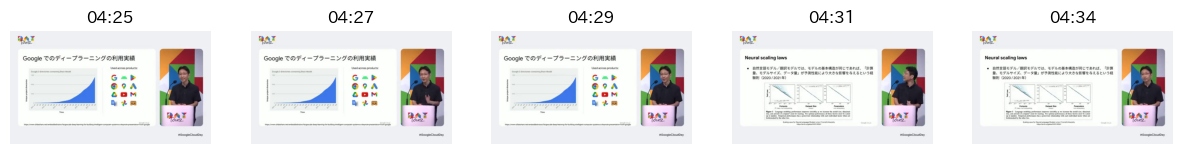

=====
中井さんがGPT-3とGLaMの性能向上について説明しています。


<Figure size 640x480 with 0 Axes>

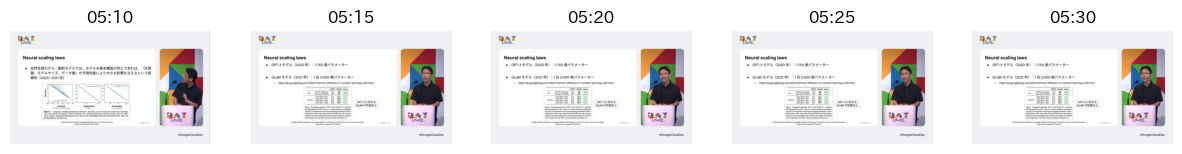

<Figure size 640x480 with 0 Axes>

In [71]:
show_thumbnails(load_json(result))

In [72]:
%%time
query = '視聴者からの質問に答えているシーン'
prompt = prompt_movie_content_search.format(query)
# prompt = [prompt] + prompt_reference
contents = UserContent([
    Part.from_text(text=prompt),
    Part.from_uri(file_uri=target_n, mime_type='video/mp4'),
])

result = generate_response(system_instruction, contents,
                           response_schema=response_schema,
                           model='gemini-2.0-flash-001')
print(result)

[
  {
    "Timestamp": "00:17-00:28",
    "Description": "中井さんが自己紹介をしています。Google Cloudのソリューションズアーキテクトです。"
  },
  {
    "Timestamp": "08:40-09:00",
    "Description": "北瀬さんと中井さんが視聴者からの質問に答えています。"
  }
]
CPU times: user 24.7 ms, sys: 3.18 ms, total: 27.9 ms
Wall time: 23.7 s


=====
中井さんが自己紹介をしています。Google Cloudのソリューションズアーキテクトです。


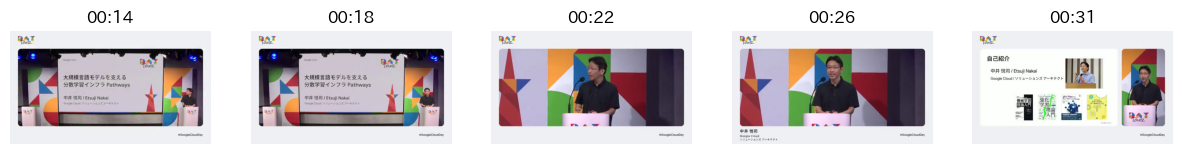

=====
北瀬さんと中井さんが視聴者からの質問に答えています。


<Figure size 640x480 with 0 Axes>

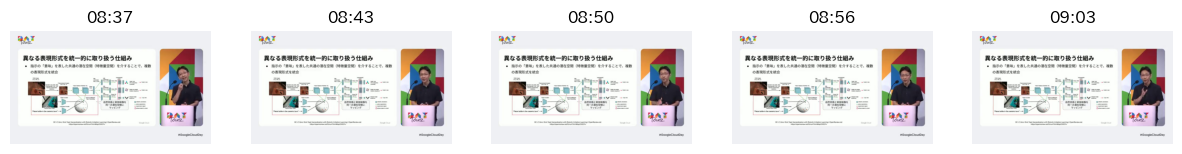

<Figure size 640x480 with 0 Axes>

In [73]:
show_thumbnails(load_json(result))

In [74]:
%%time
query = '発表者が大きく写っているシーン'
prompt = prompt_movie_content_search.format(query)
# prompt = [prompt] + prompt_reference
contents = UserContent([
    Part.from_text(text=prompt),
    Part.from_uri(file_uri=target_n, mime_type='video/mp4'),
])

result = generate_response(system_instruction, contents,
                           response_schema=response_schema,
                           model='gemini-2.0-flash-001')
print(result)

[
  {
    "Timestamp": "00:17-00:28",
    "Description": "中井さんが壇上で発表している様子が大きく写っています。"
  },
  {
    "Timestamp": "03:14-03:27",
    "Description": "中井さんが壇上で発表している様子が大きく写っています。"
  },
  {
    "Timestamp": "03:50-04:16",
    "Description": "中井さんが壇上で発表している様子が大きく写っています。"
  }
]
CPU times: user 24.1 ms, sys: 6.3 ms, total: 30.4 ms
Wall time: 24 s


=====
中井さんが壇上で発表している様子が大きく写っています。


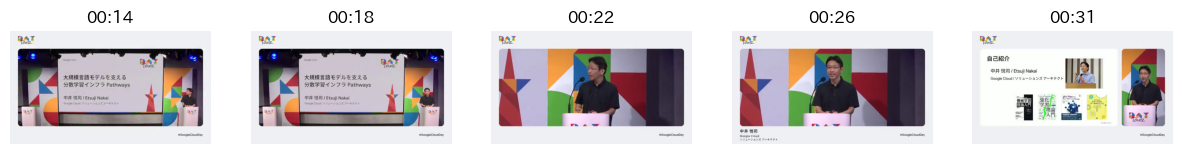

=====
中井さんが壇上で発表している様子が大きく写っています。


<Figure size 640x480 with 0 Axes>

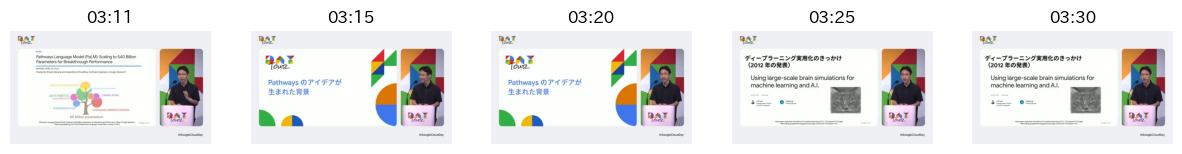

=====
中井さんが壇上で発表している様子が大きく写っています。


<Figure size 640x480 with 0 Axes>

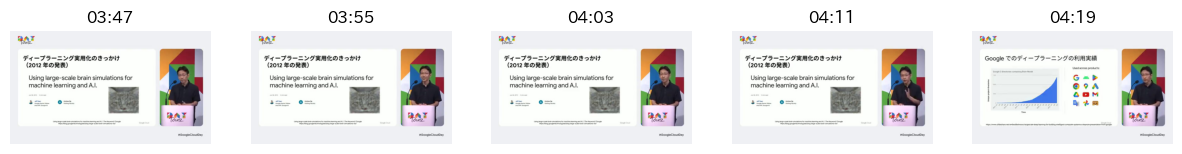

<Figure size 640x480 with 0 Axes>

In [75]:
show_thumbnails(load_json(result))

## 検索用メタテキストを保存

In [76]:
meta_text = '''\
[summary]
{}

[important scenes]
{}

[visual info]
{}

[transcription]
{}

[texts]
{}'''.format(summary, important_scenes, visual_info, transcription, texts)

metafile = f'{basename}.txt'
with open(metafile, 'w') as f:
    f.write(meta_text)

In [77]:
!gsutil cp "{metafile}" {BUCKET}/metadata/

Copying file://大規模言語モデルを支える分散学習インフラ Pathways.txt [Content-Type=text/plain]...
/ [1 files][ 98.6 KiB/ 98.6 KiB]                                                
Operation completed over 1 objects/98.6 KiB.                                     


In [78]:
print(meta_text)

[summary]
[{'Summary': 'この動画では、Google Cloudのソリューションアーキテクトである中井 '
             '悦司氏が、大規模言語モデルを支える分散学習インフラPathwaysについて解説します。中井 '
             '悦司氏は自己紹介として、機械学習、強化学習、深層学習、スケーラブルデータサイエンスに関する書籍を紹介しました。Pathwaysは、複数のタスクを同時に処理し、新しいタスクを迅速に学習し、世界をより良く理解することを反映する新しいAIアーキテクチャです。Pathways言語モデル（PaLM）は、質問応答、算術、翻訳、言語理解、要約などのタスクを実行するために、5400億のパラメータにスケーリングされています。Pathwaysのインフラストラクチャを使用した学習処理の例として、Transformerを使用した自然言語モデルが挙げられます。モデルサイズの拡大に伴う性能向上は今後も継続すると期待される一方、巨大なモデルを学習するためのインフラには限界があることが述べられています。',
  'Title': '大規模言語モデルを支える分散学習インフラPathwaysの紹介'}]

[important scenes]
{
 "results": [
  {
   "Timestamp": "00:17-00:33",
   "Description": "中井悦司氏が自己紹介を行い、機械学習、強化学習、深層学習、スケーラブルデータサイエンスに関する書籍を紹介します。"
  },
  {
   "Timestamp": "00:34-00:52",
   "Description": "Pathwaysが、複数のタスクを同時に処理し、新しいタスクを迅速に学習し、世界をより良く理解することを反映する新しいAIアーキテクチャであることが説明されます。"
  },
  {
   "Timestamp": "01:53-02:02",
   "Description": "Pathways言語モデル（PaLM）が、質問応答、算術、翻訳、言語理解、要約などのタスクを実行するために、5400億のパラメータにスケーリングされていることが示されます。"
  },
  {
   "Timestamp": "03:20-